In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import mixed_precision

# Import semua arsitektur model
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_prep
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_prep
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_prep
from tensorflow.keras.applications.densenet import preprocess_input as dense_prep
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
tf.get_logger().setLevel('ERROR')

print(f"TensorFlow: {tf.__version__}")

# Deteksi GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    mixed_precision.set_global_policy('mixed_float16')
    print(f"✅ GPU Terdeteksi: {gpus[0].name}")
else:
    print("⚠️ GPU tidak terdeteksi, menggunakan CPU")
    mixed_precision.set_global_policy('float32')


TensorFlow: 2.10.1
✅ GPU Terdeteksi: /physical_device:GPU:0


In [3]:
# Konfigurasi
DATASET_DIR = 'Dataset_Anggur'
IMG_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.2

## 2. Visualisasi sebelum dan sesudah pre-proccesing

In [4]:
def visualize_preprocessing_per_class(dataset_dir, num_samples=4):
    # Dapatkan list kelas (nama folder)
    class_list = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    
    # Setup Data Generator (Sama seperti sebelumnya)
    datagen_sample = ImageDataGenerator(
        preprocessing_function=mobile_prep, # Menggunakan mobilenet prep
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Loop untuk setiap kelas
    for class_name in class_list:
        class_path = os.path.join(dataset_dir, class_name)
        # Ambil daftar file gambar, batasi hanya sejumlah num_samples (misal 4)
        images = os.listdir(class_path)[:num_samples]
        
        # Buat Frame Plotting: Tinggi disesuaikan dengan jumlah sampel
        plt.figure(figsize=(10, 3 * num_samples)) 
        plt.suptitle(f"Sampel Kelas: {class_name}", fontsize=16, y=1.02)
        
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            
            try:
                # 1. Load Gambar Asli
                original_img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(original_img)
                
                # 2. Preprocessing
                img_batch = np.expand_dims(img_array, axis=0)
                aug_iter = datagen_sample.flow(img_batch, batch_size=1)
                aug_img = next(aug_iter)[0]
                
                # Normalisasi untuk visualisasi (karena prepro bikin nilai jadi aneh/negatif)
                display_aug = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min())

                # Plot Gambar Asli (Kolom Kiri)
                plt.subplot(num_samples, 2, 2*i + 1)
                if i == 0: plt.title("Sebelum (Original)")
                plt.imshow(img_array.astype('uint8'))
                plt.axis('off')
                
                # Plot Gambar Hasil Prepro (Kolom Kanan)
                plt.subplot(num_samples, 2, 2*i + 2)
                if i == 0: plt.title("Sesudah (Prepro + Augmentasi)")
                plt.imshow(display_aug)
                plt.axis('off')
                
            except Exception as e:
                print(f"Error memproses gambar {img_name}: {e}")
                continue

        plt.tight_layout()
        plt.show()
        print("-" * 80) # Separator antar kelas

Visualisasi 4 Sampel Per Kelas:


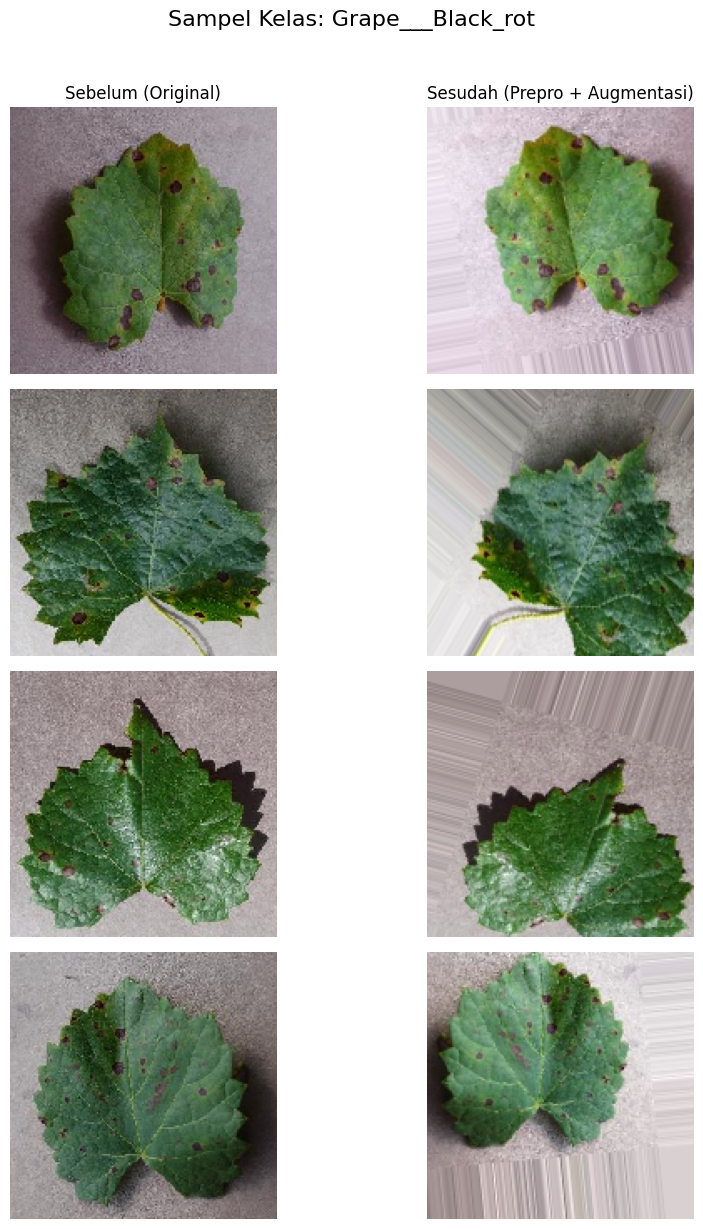

--------------------------------------------------------------------------------


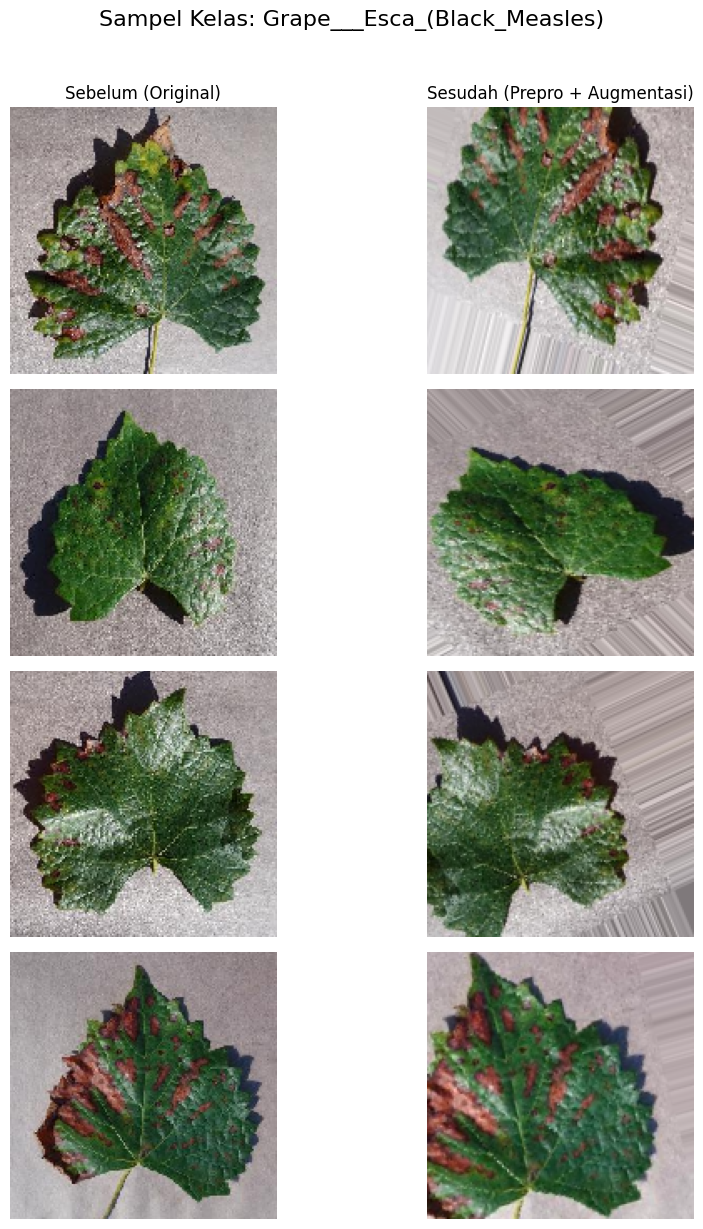

--------------------------------------------------------------------------------


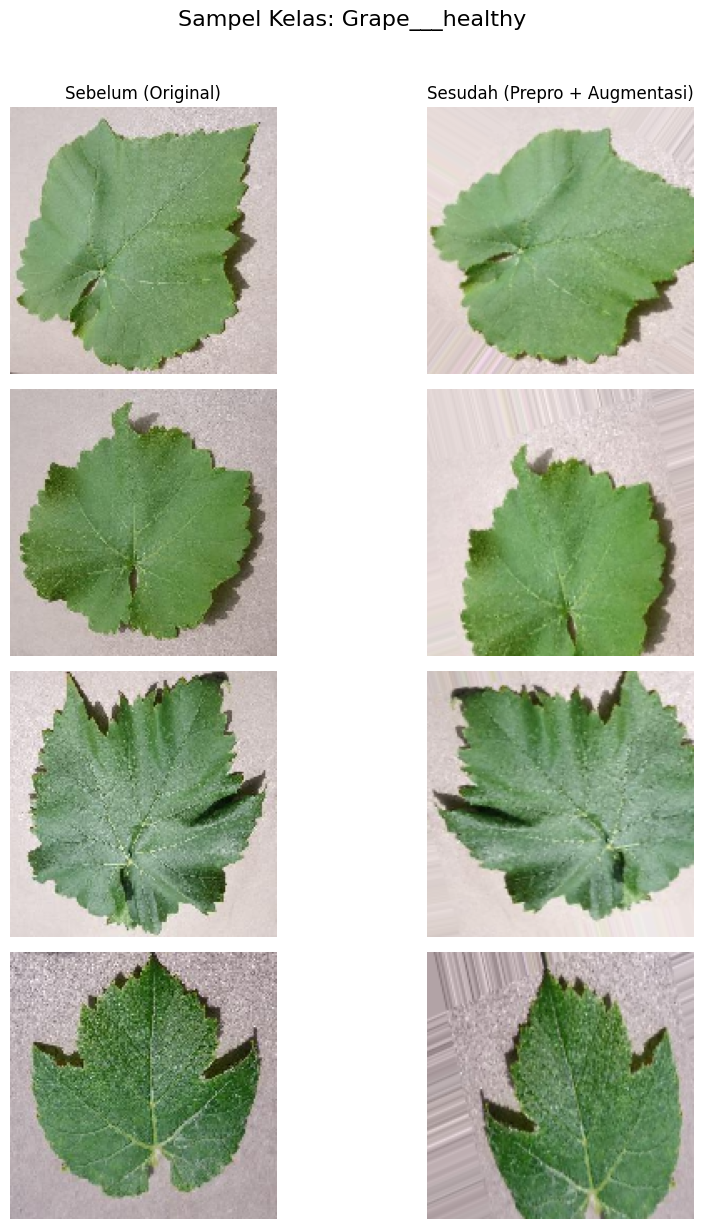

--------------------------------------------------------------------------------


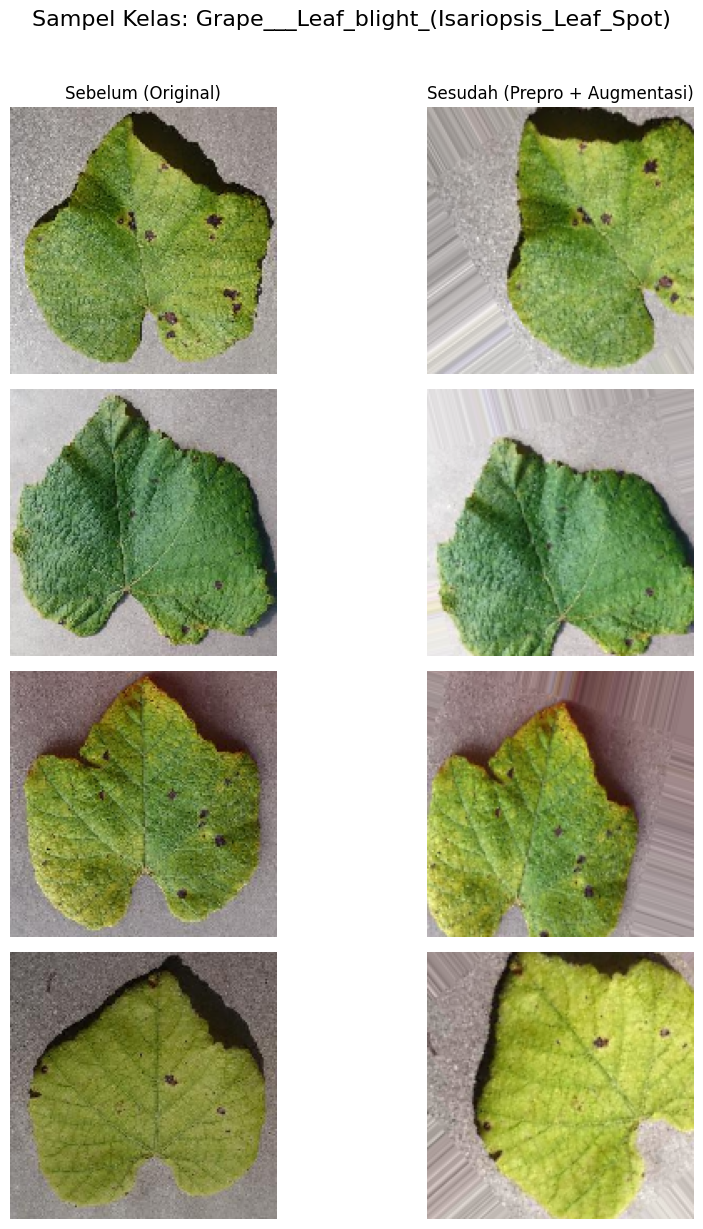

--------------------------------------------------------------------------------


In [5]:
# Jalankan Fungsi
print("Visualisasi 4 Sampel Per Kelas:")
try:
    visualize_preprocessing_per_class(DATASET_DIR, num_samples=4)
except Exception as e:
    print(f"Gagal: {e}")

## 3. Definisi 6 Model 

In [6]:
# 1. Custom CNN (Baseline)
def build_custom_cnn(num_classes):
    model = Sequential(name='Custom_CNN')
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [7]:

# 2. MobileNetV2 (Transfer Learning - Ringan)
def build_mobilenet(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True # Fine Tuning
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='MobileNetV2')


In [8]:

# 3. ResNet50V2 (Residual Network - Menengah/Berat)
def build_resnet50(num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='ResNet50V2')


In [9]:
# 4. VGG16 (Deep CNN Klasik - Berat)
def build_vgg16(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions, name='VGG16')


In [10]:
# 5. EfficientNetB0 (Sangat Direkomendasikan)
def build_efficientnet(num_classes):
    # EfficientNet biasanya butuh input shape (224, 224, 3)
    # Weights='imagenet' agar transfer learning jalan
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # EfficientNetB0 bisa di-unfreeze beberapa layer atasnya agar adaptasi lebih baik
    # Tapi untuk awal, kita freeze dulu atau trainable=True semua juga oke jika LR kecil
    base_model.trainable = True 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x) # Tambahan Batchnorm sering membantu di EfficientNet
    x = Dropout(0.2)(x)         # Dropout agar tidak overfitting
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions, name='EfficientNetB0')


In [11]:
# 6. DenseNet121 (Alternatif Kuat)
def build_densenet(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions, name='DenseNet121')

## 4. Training Loop & Evaluasi Komparatif

In [12]:
# --- 1. Konfigurasi Model ---
models_config = [
    ('DenseNet121', build_densenet, dense_prep),
    ('EfficientNetB0', build_efficientnet, eff_prep),
    ('Custom CNN', build_custom_cnn, None),
    ('MobileNetV2', build_mobilenet, mobile_prep),
    ('ResNet50V2', build_resnet50, resnet_prep),
    ('VGG16', build_vgg16, vgg_prep)
]

history_storage = {}
final_accuracies = {}

In [13]:
# --- 2. Hitung Bobot Kelas (Class Weights) --
print("Menghitung bobot kelas dan memuat data...")
# Gunakan generator sementara untuk scanning data
dummy_gen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_RATIO)
temp_gen = dummy_gen.flow_from_directory(DATASET_DIR, subset='training')

NUM_CLASSES = temp_gen.num_classes
class_names = list(temp_gen.class_indices.keys())
cls_train = temp_gen.classes

# Hitung bobot agar training adil (balanced)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(cls_train), 
    y=cls_train
)

weights_dict = {i: float(w) for i, w in enumerate(class_weights)}

print(f"Kelas Terdeteksi: {class_names}")
print(f"Bobot Kelas: {weights_dict}")

Menghitung bobot kelas dan memuat data...
Found 3251 images belonging to 4 classes.
Kelas Terdeteksi: ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']
Bobot Kelas: {0: 0.8609639830508474, 1: 0.7341915085817525, 2: 0.9439605110336817, 3: 2.3974926253687316}


In [14]:
# --- 3. Loop Training Semua Model ---

# Dictionary untuk menyimpan model dan prediksi
saved_models = {}
model_predictions = {}

# Buat folder untuk menyimpan model
os.makedirs('saved_models', exist_ok=True)

for name, builder, preproc_func in models_config:
    print(f"\n{'='*50}")
    print(f"MULAI TRAINING: {name}")
    print(f"{'='*50}")
    
    # A. Siapkan Generator Khusus
    if preproc_func is None:
        # Untuk Custom CNN (perlu rescale manual)
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30, 
            width_shift_range=0.2, 
            height_shift_range=0.2,
            shear_range=0.2, 
            zoom_range=0.2, 
            horizontal_flip=True,
            validation_split=SPLIT_RATIO
        )
    else:
        # Untuk Transfer Learning (gunakan fungsi preprocess bawaan)
        train_datagen = ImageDataGenerator(
            preprocessing_function=preproc_func,
            rotation_range=30, 
            width_shift_range=0.2, 
            height_shift_range=0.2,
            shear_range=0.2, 
            zoom_range=0.2, 
            horizontal_flip=True,
            validation_split=SPLIT_RATIO
        )

    # B. Buat Flow Data
    train_generator = train_datagen.flow_from_directory(
        DATASET_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='training', 
        shuffle=True
    )
    
    test_generator = train_datagen.flow_from_directory(
        DATASET_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE, 
        class_mode='categorical', 
        subset='validation', 
        shuffle=False
    )

    # C. Build & Compile Model
    tf.keras.backend.clear_session()  # Hapus sesi lama agar RAM lega
    gc.collect()  # Force garbage collection
    
    model = builder(NUM_CLASSES)
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # D. Proses Training
    # Menggunakan len(generator) agar tidak muncul warning 'ran out of data'
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), 
        validation_data=test_generator,
        validation_steps=len(test_generator),
        epochs=EPOCHS,
        class_weight=weights_dict,
        verbose=1
    )
    
    # E. Simpan History
    history_storage[name] = history.history
    
    # F. Evaluasi Akhir
    print(f"\nEvaluasi Akhir {name}:")
    loss, acc = model.evaluate(test_generator, verbose=0)
    final_accuracies[name] = acc * 100
    print(f"--> Akurasi Validasi: {acc*100:.2f}%")
    
    # G. Simpan Prediksi untuk Confusion Matrix
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    model_predictions[name] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'predictions': predictions,
        'preproc_func': preproc_func,
        'builder': builder  # Simpan builder untuk load ulang
    }
    
    # H. Simpan WEIGHTS saja ke folder saved_models (menghindari error serialisasi)
    model_filename = name.lower().replace(' ', '_') + '_weights.h5'
    model_path = os.path.join('saved_models', model_filename)
    model.save_weights(model_path)
    saved_models[name] = model_path
    print(f"✅ Model weights disimpan: {model_path}")
    
    # I. Bersihkan memori setelah setiap model
    del model
    gc.collect()
    tf.keras.backend.clear_session()

print("\n" + "="*50)
print("✅ TRAINING SELESAI UNTUK SEMUA MODEL!")
print("="*50)
print(f"\n📁 Model tersimpan di folder: saved_models/")
for name, path in saved_models.items():
    print(f"   • {name}: {path}")


MULAI TRAINING: DenseNet121
Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.
Epoch 1/10
204/204 [==============================] - 46s 146ms/step - loss: 0.3249 - accuracy: 0.8782 - val_loss: 0.0631 - val_accuracy: 0.9803
Epoch 2/10
204/204 [==============================] - 29s 143ms/step - loss: 0.0723 - accuracy: 0.9760 - val_loss: 0.0142 - val_accuracy: 0.9963
Epoch 3/10
204/204 [==============================] - 30s 146ms/step - loss: 0.0536 - accuracy: 0.9794 - val_loss: 0.0093 - val_accuracy: 0.9975
Epoch 4/10
204/204 [==============================] - 29s 143ms/step - loss: 0.0418 - accuracy: 0.9840 - val_loss: 0.0191 - val_accuracy: 0.9926
Epoch 5/10
204/204 [==============================] - 30s 145ms/step - loss: 0.0325 - accuracy: 0.9883 - val_loss: 0.0049 - val_accuracy: 0.9988
Epoch 6/10
204/204 [==============================] - 30s 147ms/step - loss: 0.0472 - accuracy: 0.9831 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 7/10
204/204

## 5. Komparasi Hasil (Grafik)

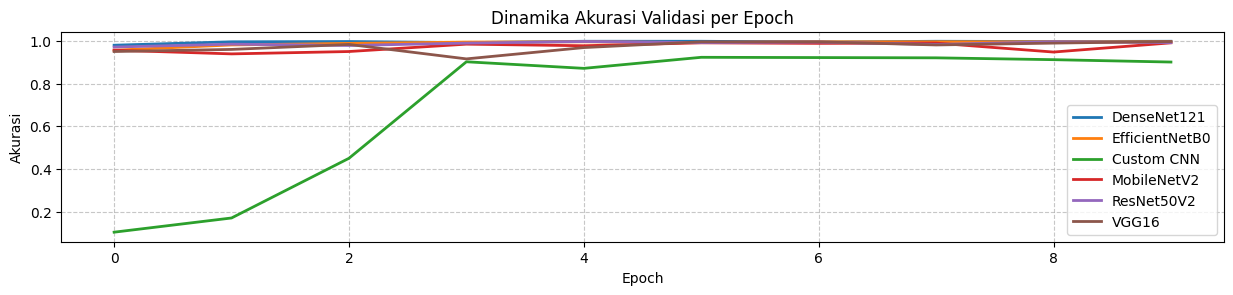

In [15]:
import matplotlib.cm as cm


# Setup Ukuran Plot
plt.figure(figsize=(15, 6))

# --- Subplot 1: Kurva Akurasi Validasi ---
plt.subplot(2, 1, 1)
for name, hist in history_storage.items():
    # Mengambil val_accuracy (pastikan key-nya sesuai versi keras, biasanya 'val_accuracy')
    acc_data = hist.get('val_accuracy') or hist.get('val_acc') 
    if acc_data:
        plt.plot(acc_data, label=name, linewidth=2)

plt.title('Dinamika Akurasi Validasi per Epoch')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)


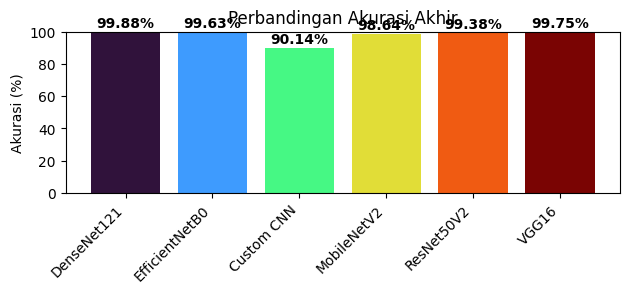

In [16]:

# --- Subplot 2: Bar Chart Akurasi Akhir ---
plt.subplot(2, 1, 2)
names = list(final_accuracies.keys())
values = list(final_accuracies.values())

# PERBAIKAN 1: Membuat warna dinamis sesuai jumlah model (agar tidak error)
colors = cm.turbo(np.linspace(0, 1, len(names))) 

bars = plt.bar(names, values, color=colors)

plt.title('Perbandingan Akurasi Akhir')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100) # Batas y dari 0 sampai 100

# PERBAIKAN 2: Memiringkan nama model agar tidak bertumpuk
plt.xticks(rotation=45, ha='right')

# Tambahkan label angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 1, 
        f"{yval:.2f}%", 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

CONFUSION MATRIX UNTUK SEMUA MODEL


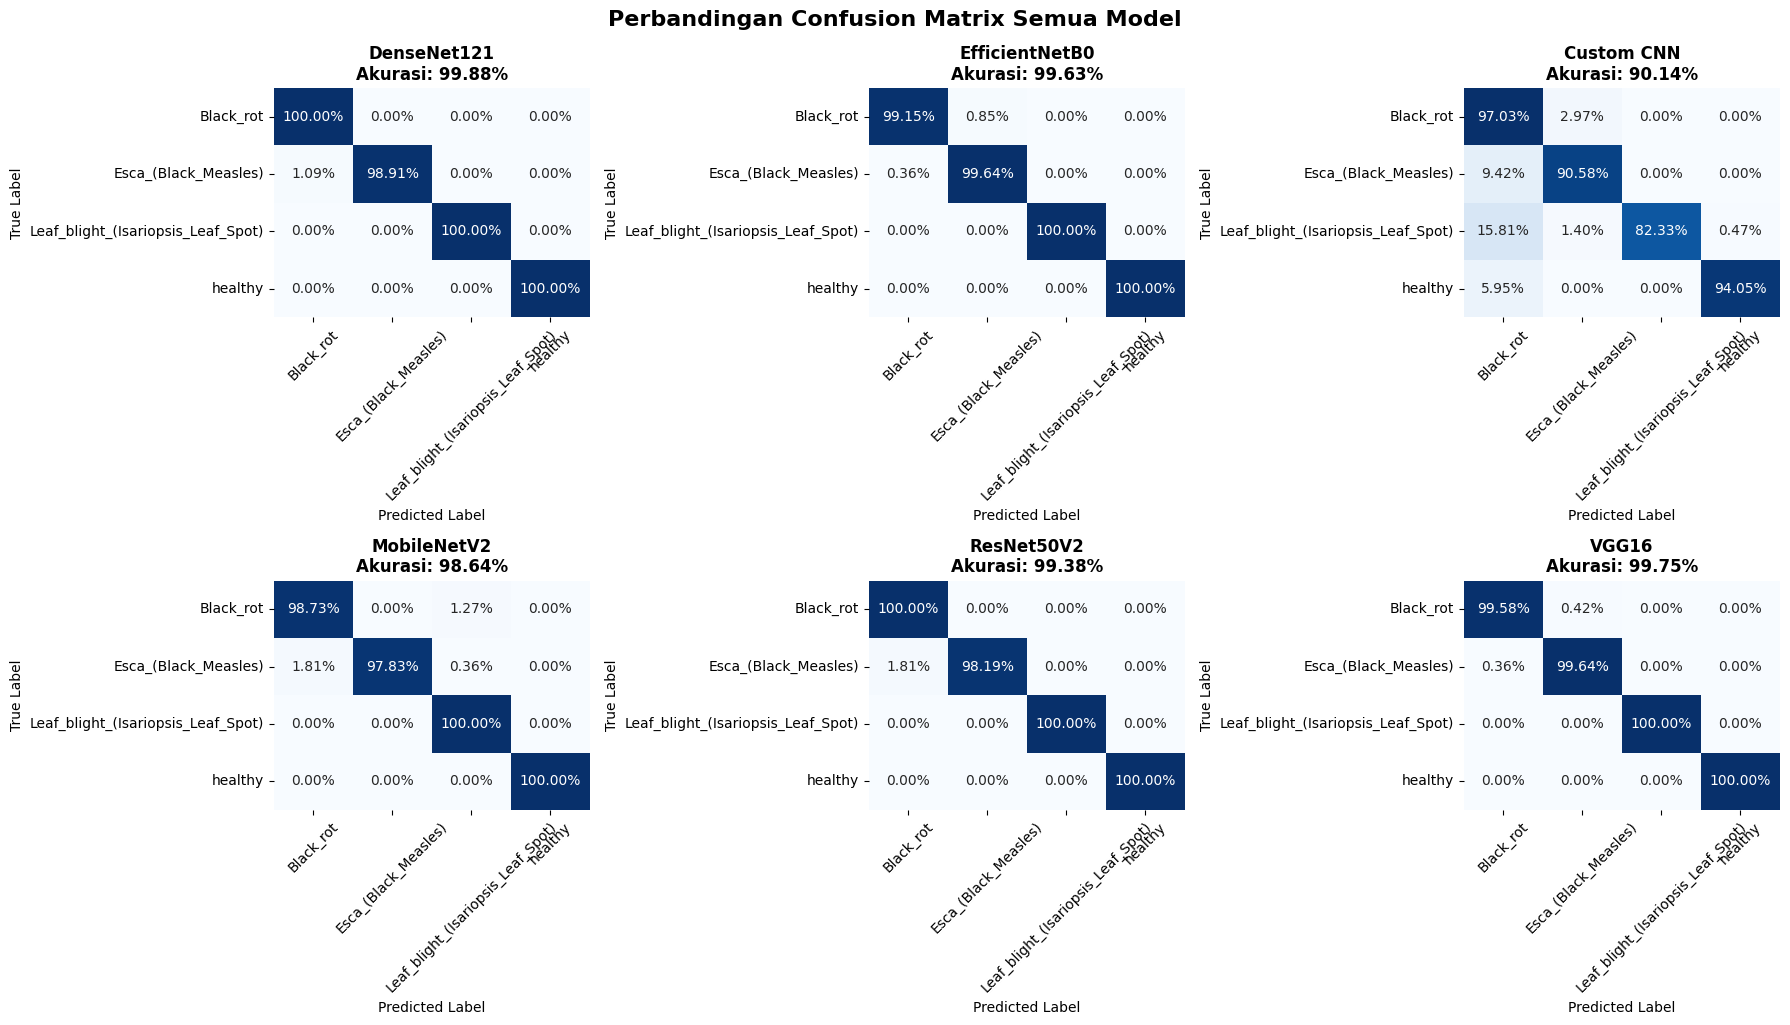

In [17]:
# --- 5.3 Confusion Matrix untuk Semua Model ---
print("="*60)
print("CONFUSION MATRIX UNTUK SEMUA MODEL")
print("="*60)

# Buat grid untuk confusion matrix
n_models = len(model_predictions)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, (name, pred_data) in enumerate(model_predictions.items()):
    y_true = pred_data['y_true']
    y_pred = pred_data['y_pred']
    
    # Hitung Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    ax = axes[idx]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=[c.replace('Grape___', '') for c in class_names],
                yticklabels=[c.replace('Grape___', '') for c in class_names],
                ax=ax, cbar=False)
    
    # Hitung akurasi
    acc = final_accuracies[name]
    ax.set_title(f'{name}\nAkurasi: {acc:.2f}%', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Hapus subplot kosong jika ada
for idx in range(len(model_predictions), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Perbandingan Confusion Matrix Semua Model', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [18]:
# --- 5.4 Classification Report untuk Semua Model ---
print("="*60)
print("CLASSIFICATION REPORT UNTUK SEMUA MODEL")
print("="*60)

# Simpan metrics untuk perbandingan
all_metrics = {}

for name, pred_data in model_predictions.items():
    y_true = pred_data['y_true']
    y_pred = pred_data['y_pred']
    
    print(f"\n{'='*50}")
    print(f"📊 CLASSIFICATION REPORT: {name}")
    print(f"{'='*50}")
    
    # Generate classification report
    target_names = [c.replace('Grape___', '') for c in class_names]
    report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
    
    # Print report
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    
    # Simpan metrics
    all_metrics[name] = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall']
    }

print("\n" + "="*60)
print("RINGKASAN METRIK SEMUA MODEL")
print("="*60)
print(f"\n{'Model':<20} {'Accuracy':>10} {'Macro F1':>10} {'Weighted F1':>12} {'Precision':>10} {'Recall':>10}")
print("-"*75)

for name, metrics in all_metrics.items():
    print(f"{name:<20} {metrics['accuracy']*100:>9.2f}% {metrics['macro_f1']*100:>9.2f}% {metrics['weighted_f1']*100:>11.2f}% {metrics['macro_precision']*100:>9.2f}% {metrics['macro_recall']*100:>9.2f}%")

CLASSIFICATION REPORT UNTUK SEMUA MODEL

📊 CLASSIFICATION REPORT: DenseNet121
                                    precision    recall  f1-score   support

                         Black_rot     0.9874    1.0000    0.9937       236
              Esca_(Black_Measles)     1.0000    0.9891    0.9945       276
Leaf_blight_(Isariopsis_Leaf_Spot)     1.0000    1.0000    1.0000       215
                           healthy     1.0000    1.0000    1.0000        84

                          accuracy                         0.9963       811
                         macro avg     0.9969    0.9973    0.9971       811
                      weighted avg     0.9963    0.9963    0.9963       811


📊 CLASSIFICATION REPORT: EfficientNetB0
                                    precision    recall  f1-score   support

                         Black_rot     0.9957    0.9915    0.9936       236
              Esca_(Black_Measles)     0.9928    0.9964    0.9946       276
Leaf_blight_(Isariopsis_Leaf_Spot)     1.

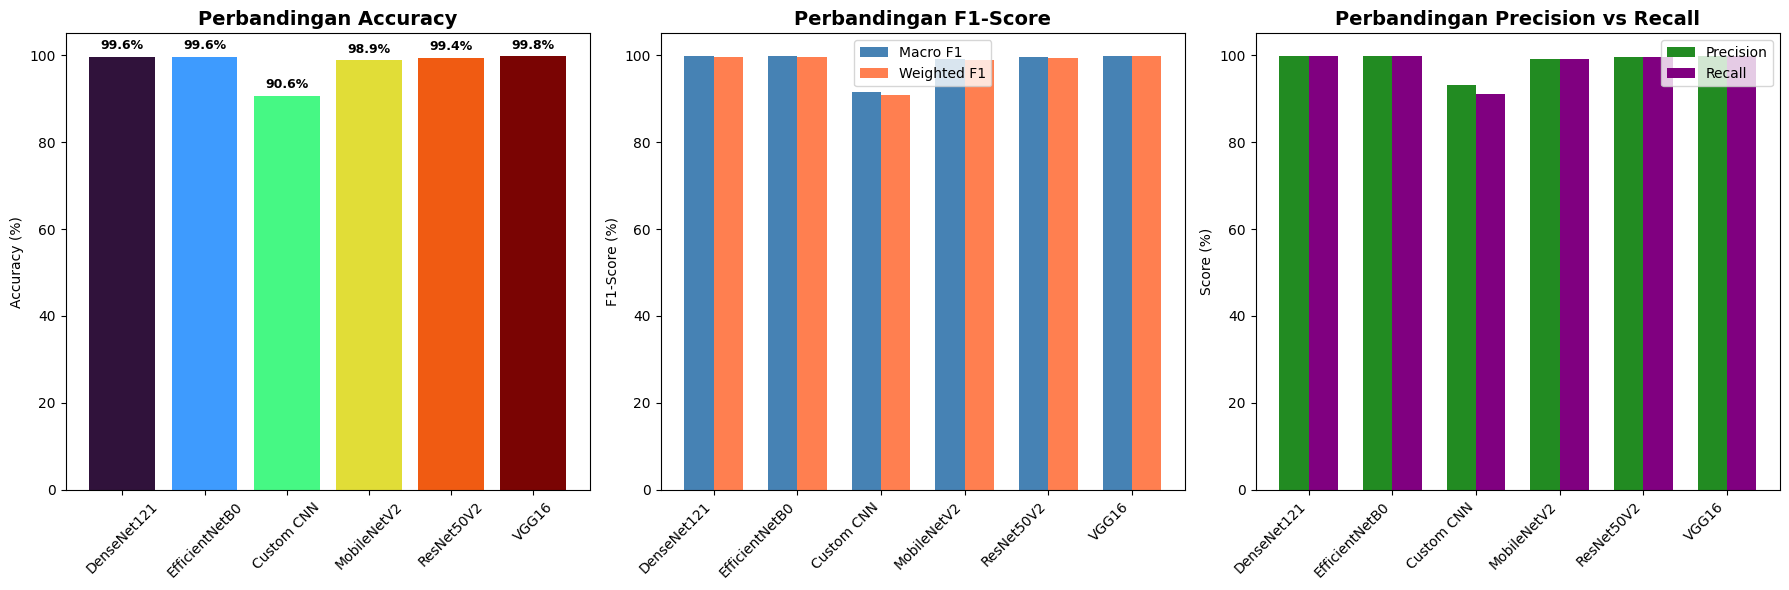


🏆 MODEL TERBAIK: VGG16 dengan Akurasi 99.75%


In [50]:
# --- 5.5 Visualisasi Perbandingan Metrik ---
import matplotlib.cm as mpl_cm

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

model_names = list(all_metrics.keys())
colors = mpl_cm.turbo(np.linspace(0, 1, len(model_names)))

# 1. Bar Chart Accuracy
ax1 = axes[0]
accuracies = [all_metrics[m]['accuracy'] * 100 for m in model_names]
bars1 = ax1.bar(model_names, accuracies, color=colors)
ax1.set_title('Perbandingan Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 105)
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Bar Chart F1-Score (Macro vs Weighted)
ax2 = axes[1]
x = np.arange(len(model_names))
width = 0.35
macro_f1 = [all_metrics[m]['macro_f1'] * 100 for m in model_names]
weighted_f1 = [all_metrics[m]['weighted_f1'] * 100 for m in model_names]

bars2a = ax2.bar(x - width/2, macro_f1, width, label='Macro F1', color='steelblue')
bars2b = ax2.bar(x + width/2, weighted_f1, width, label='Weighted F1', color='coral')
ax2.set_title('Perbandingan F1-Score', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score (%)')
ax2.set_ylim(0, 105)
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.legend()

# 3. Bar Chart Precision vs Recall
ax3 = axes[2]
precision = [all_metrics[m]['macro_precision'] * 100 for m in model_names]
recall = [all_metrics[m]['macro_recall'] * 100 for m in model_names]

bars3a = ax3.bar(x - width/2, precision, width, label='Precision', color='forestgreen')
bars3b = ax3.bar(x + width/2, recall, width, label='Recall', color='purple')
ax3.set_title('Perbandingan Precision vs Recall', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score (%)')
ax3.set_ylim(0, 105)
ax3.set_xticks(x)
ax3.set_xticklabels(model_names, rotation=45, ha='right')
ax3.legend()

plt.tight_layout()
plt.show()

# Tentukan model terbaik
best_model = max(all_metrics, key=lambda x: all_metrics[x]['accuracy'])
print(f"\n🏆 MODEL TERBAIK: {best_model} dengan Akurasi {all_metrics[best_model]['accuracy']*100:.2f}%")

## 6. Demo Prediksi dengan Input Index

Pada bagian ini, kita akan membuat demo untuk memprediksi gambar dari dataset menggunakan **index**. User dapat memilih:
1. **Index gambar** dari data validasi
2. **Model** yang ingin digunakan untuk prediksi

Hasil prediksi akan menampilkan gambar, label sebenarnya, label prediksi, dan confidence score.

In [56]:
# --- 6.1 Persiapan Data Validasi untuk Demo ---
print("="*60)
print("PERSIAPAN DATA VALIDASI UNTUK DEMO")
print("="*60)

# Buat generator tanpa augmentasi untuk mengambil gambar asli
demo_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_RATIO)

demo_generator = demo_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,  # Batch size 1 untuk akses per gambar
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Ambil semua gambar validasi
all_validation_images = []
all_validation_labels = []
all_filenames = demo_generator.filenames

demo_generator.reset()
for i in range(len(demo_generator)):
    img, label = next(demo_generator)
    all_validation_images.append(img[0])
    all_validation_labels.append(np.argmax(label[0]))

all_validation_images = np.array(all_validation_images)
all_validation_labels = np.array(all_validation_labels)

print(f"✅ Total gambar validasi: {len(all_validation_images)}")
print(f"✅ Kelas tersedia: {class_names}")
print(f"\n📋 Distribusi data validasi:")
for i, name in enumerate(class_names):
    count = np.sum(all_validation_labels == i)
    print(f"   [{i}] {name}: {count} gambar")

print(f"\n💡 Gunakan index 0 - {len(all_validation_images)-1} untuk memilih gambar")

PERSIAPAN DATA VALIDASI UNTUK DEMO
Found 811 images belonging to 4 classes.
✅ Total gambar validasi: 811
✅ Kelas tersedia: ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']

📋 Distribusi data validasi:
   [0] Grape___Black_rot: 236 gambar
   [1] Grape___Esca_(Black_Measles): 276 gambar
   [2] Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 215 gambar
   [3] Grape___healthy: 84 gambar

💡 Gunakan index 0 - 810 untuk memilih gambar


In [64]:
# --- 6.2 Fungsi Demo Prediksi ---

def predict_by_index(image_index, model_name='DenseNet121'):
    
    # Validasi index
    if image_index < 0 or image_index >= len(all_validation_images):
        print(f"❌ Error: Index harus antara 0 dan {len(all_validation_images)-1}")
        return None
    
    # Validasi model name
    if model_name not in saved_models:
        print(f"❌ Error: Model '{model_name}' tidak ditemukan!")
        print(f"   Model tersedia: {list(saved_models.keys())}")
        return None
    
    # --- PERBAIKAN DI SINI ---
    print(f"🔄 Membangun dan memuat bobot model {model_name}...")
    
    # 1. Ambil fungsi builder yang disimpan saat training
    builder = model_predictions[model_name]['builder']
    
    # 2. Bangun arsitektur model dari nol
    model = builder(NUM_CLASSES)
    
    # 3. Load hanya bobotnya (karena file .h5 hanya berisi weights)
    model.load_weights(saved_models[model_name])
    
    # 4. Compile (opsional tapi disarankan)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # -------------------------
    
    # Ambil gambar dan label sebenarnya
    img = all_validation_images[image_index]
    true_label_idx = all_validation_labels[image_index]
    true_label = class_names[true_label_idx].replace('Grape___', '')
    filename = all_filenames[image_index]
    
    # Preprocessing sesuai model
    preproc_func = model_predictions[model_name]['preproc_func']
    
    if preproc_func is None:
        # Custom CNN - sudah rescale 1/255
        img_preprocessed = img.copy()
    else:
        # Transfer learning - perlu preprocessing khusus
        img_preprocessed = img * 255  # Kembalikan ke 0-255
        img_preprocessed = preproc_func(img_preprocessed)
    
    # Prediksi
    img_batch = np.expand_dims(img_preprocessed, axis=0)
    predictions = model.predict(img_batch, verbose=0)
    pred_label_idx = np.argmax(predictions[0])
    pred_label = class_names[pred_label_idx].replace('Grape___', '')
    confidence = predictions[0][pred_label_idx] * 100
    
    # Visualisasi
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Tampilkan gambar
    axes[0].imshow(img)
    axes[0].axis('off')
    
    # Warna title berdasarkan benar/salah
    color = 'green' if pred_label_idx == true_label_idx else 'red'
    status = '✅ BENAR' if pred_label_idx == true_label_idx else '❌ SALAH'
    
    axes[0].set_title(f'Index: {image_index}\nFile: {filename}\n\nTrue: {true_label}\nPredicted: {pred_label}\nConfidence: {confidence:.2f}%\n{status}', 
                      fontsize=12, color=color, fontweight='bold')
    
    # 2. Bar chart confidence per kelas
    class_labels = [c.replace('Grape___', '') for c in class_names]
    probs = predictions[0] * 100
    colors = ['green' if i == pred_label_idx else 'steelblue' for i in range(len(class_labels))]
    
    bars = axes[1].barh(class_labels, probs, color=colors)
    axes[1].set_xlabel('Confidence (%)')
    axes[1].set_title(f'Distribusi Probabilitas\nModel: {model_name}', fontsize=12, fontweight='bold')
    axes[1].set_xlim(0, 105)
    
    # Tambahkan label nilai
    for bar, prob in zip(bars, probs):
        axes[1].text(prob + 1, bar.get_y() + bar.get_height()/2, 
                     f'{prob:.2f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Cleanup
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
    return {
        'index': image_index,
        'filename': filename,
        'true_label': true_label,
        'predicted_label': pred_label,
        'confidence': confidence,
        'is_correct': pred_label_idx == true_label_idx,
        'all_probabilities': dict(zip(class_labels, probs.tolist()))
    }

print("✅ Fungsi predict_by_index() siap digunakan!")
print("\n📋 Model tersedia:", list(saved_models.keys()))

✅ Fungsi predict_by_index() siap digunakan!

📋 Model tersedia: ['DenseNet121', 'EfficientNetB0', 'Custom CNN', 'MobileNetV2', 'ResNet50V2', 'VGG16']


DEMO PREDIKSI - Index: 0, Model: DenseNet121
🔄 Membangun dan memuat bobot model DenseNet121...


C:\Users\ROG FLOWX13\AppData\Local\Temp\ipykernel_35976\1503810871.py:85: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ROG FLOWX13\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


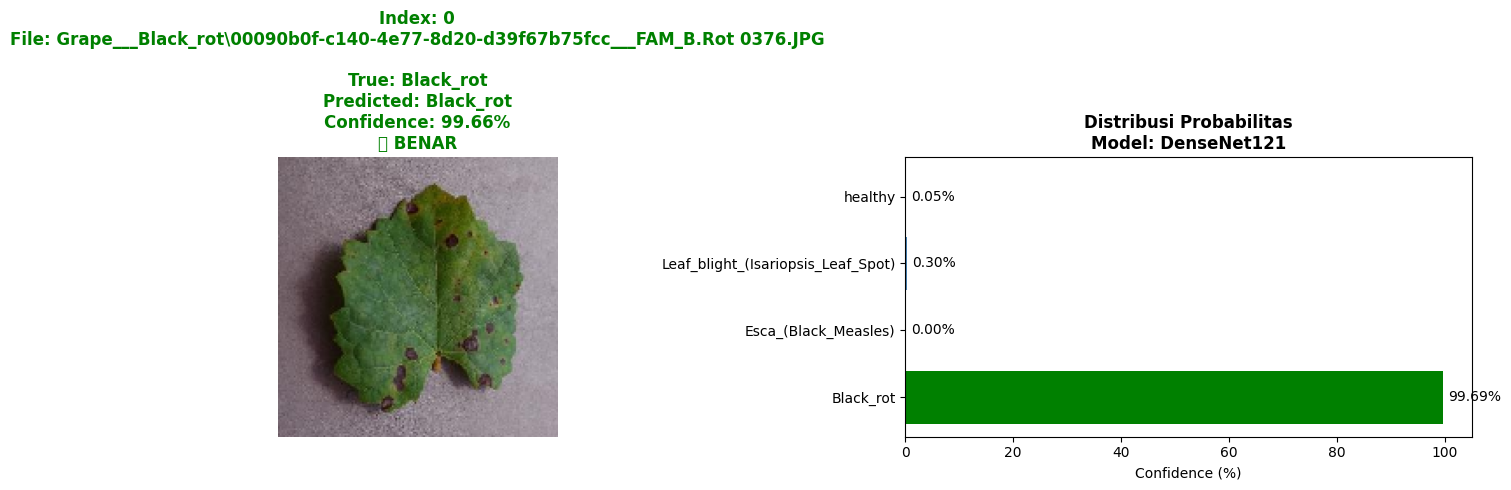


📊 Hasil Prediksi:
   • Index: 0
   • File: Grape___Black_rot\00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG
   • Label Sebenarnya: Black_rot
   • Label Prediksi: Black_rot
   • Confidence: 99.66%
   • Status: ✅ BENAR


In [65]:
# --- 6.3 Contoh Demo: Prediksi Gambar dengan Index ---

# ============================================
# 🎯 UBAH NILAI DI BAWAH INI UNTUK DEMO
# ============================================
IMAGE_INDEX = 0          # Ganti dengan index gambar (0 - total_gambar-1)
MODEL_NAME = 'DenseNet121'  # Pilih: 'DenseNet121', 'EfficientNetB0', 'Custom CNN', 'MobileNetV2', 'ResNet50V2', 'VGG16'
# ============================================

print("="*60)
print(f"DEMO PREDIKSI - Index: {IMAGE_INDEX}, Model: {MODEL_NAME}")
print("="*60)

result = predict_by_index(image_index=IMAGE_INDEX, model_name=MODEL_NAME)

if result:
    print("\n📊 Hasil Prediksi:")
    print(f"   • Index: {result['index']}")
    print(f"   • File: {result['filename']}")
    print(f"   • Label Sebenarnya: {result['true_label']}")
    print(f"   • Label Prediksi: {result['predicted_label']}")
    print(f"   • Confidence: {result['confidence']:.2f}%")
    print(f"   • Status: {'✅ BENAR' if result['is_correct'] else '❌ SALAH'}")

In [66]:
# --- 6.4 Demo Perbandingan Prediksi Semua Model pada Satu Gambar ---

def compare_all_models(image_index):
    """
    Membandingkan prediksi semua model pada satu gambar yang sama.
    """
    
    # Validasi index
    if image_index < 0 or image_index >= len(all_validation_images):
        print(f"❌ Error: Index harus antara 0 dan {len(all_validation_images)-1}")
        return
    
    # Ambil gambar dan label sebenarnya
    img = all_validation_images[image_index]
    true_label_idx = all_validation_labels[image_index]
    true_label = class_names[true_label_idx].replace('Grape___', '')
    filename = all_filenames[image_index]
    
    print("="*60)
    print(f"PERBANDINGAN PREDIKSI SEMUA MODEL")
    print(f"Index: {image_index} | File: {filename}")
    print(f"Label Sebenarnya: {true_label}")
    print("="*60)
    
    # Setup plot
    n_models = len(saved_models)
    fig, axes = plt.subplots(2, n_models + 1, figsize=(4*(n_models+1), 8))
    
    # Baris 1, Kolom 1: Gambar asli
    axes[0, 0].imshow(img)
    axes[0, 0].set_title(f'Gambar Asli\nIndex: {image_index}\nTrue: {true_label}', 
                         fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    results = {}
    
    for idx, (model_name, model_path) in enumerate(saved_models.items(), 1):
        # --- PERBAIKAN DI SINI ---
        # 1. Ambil builder
        builder = model_predictions[model_name]['builder']
        # 2. Bangun ulang
        model = builder(NUM_CLASSES)
        # 3. Load bobot
        model.load_weights(model_path)
        # -------------------------
        
        # Preprocessing
        preproc_func = model_predictions[model_name]['preproc_func']
        
        if preproc_func is None:
            img_preprocessed = img.copy()
        else:
            img_preprocessed = img * 255
            img_preprocessed = preproc_func(img_preprocessed)
        
        # Prediksi
        img_batch = np.expand_dims(img_preprocessed, axis=0)
        predictions = model.predict(img_batch, verbose=0)
        pred_label_idx = np.argmax(predictions[0])
        pred_label = class_names[pred_label_idx].replace('Grape___', '')
        confidence = predictions[0][pred_label_idx] * 100
        
        is_correct = pred_label_idx == true_label_idx
        results[model_name] = {
            'pred_label': pred_label,
            'confidence': confidence,
            'is_correct': is_correct
        }
        
        # Plot - Baris 1: Status prediksi
        color = 'green' if is_correct else 'red'
        status = '✅' if is_correct else '❌'
        
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f'{model_name}\nPred: {pred_label}\nConf: {confidence:.1f}% {status}', 
                               fontsize=9, color=color, fontweight='bold')
        axes[0, idx].axis('off')
        
        # Plot - Baris 2: Bar confidence
        class_labels = [c.replace('Grape___', '') for c in class_names]
        probs = predictions[0] * 100
        colors = ['green' if i == pred_label_idx else 'lightgray' for i in range(len(class_labels))]
        
        axes[1, idx].barh(class_labels, probs, color=colors)
        axes[1, idx].set_xlim(0, 105)
        axes[1, idx].set_xlabel('Conf (%)', fontsize=8)
        axes[1, idx].tick_params(axis='y', labelsize=7)
        
        # Cleanup
        del model
        gc.collect()
    
    tf.keras.backend.clear_session()
    plt.tight_layout()
    plt.show()
    
    # Ringkasan
    print("\n📊 RINGKASAN PREDIKSI:")
    print("-"*60)
    correct_count = sum(1 for r in results.values() if r['is_correct'])
    print(f"Model yang prediksi BENAR: {correct_count}/{len(results)}")
    print("-"*60)
    
    for model_name, r in results.items():
        status = '✅' if r['is_correct'] else '❌'
        print(f"   {model_name:<15}: {r['pred_label']:<20} ({r['confidence']:.1f}%) {status}")
    
    return results

print("✅ Fungsi compare_all_models() siap digunakan!")

✅ Fungsi compare_all_models() siap digunakan!


PERBANDINGAN PREDIKSI SEMUA MODEL
Index: 50 | File: Grape___Black_rot\0aec6325-48be-4373-886d-fff5aeea6d26___FAM_B.Rot 3465.JPG
Label Sebenarnya: Black_rot


C:\Users\ROG FLOWX13\AppData\Local\Temp\ipykernel_35976\4051380419.py:95: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


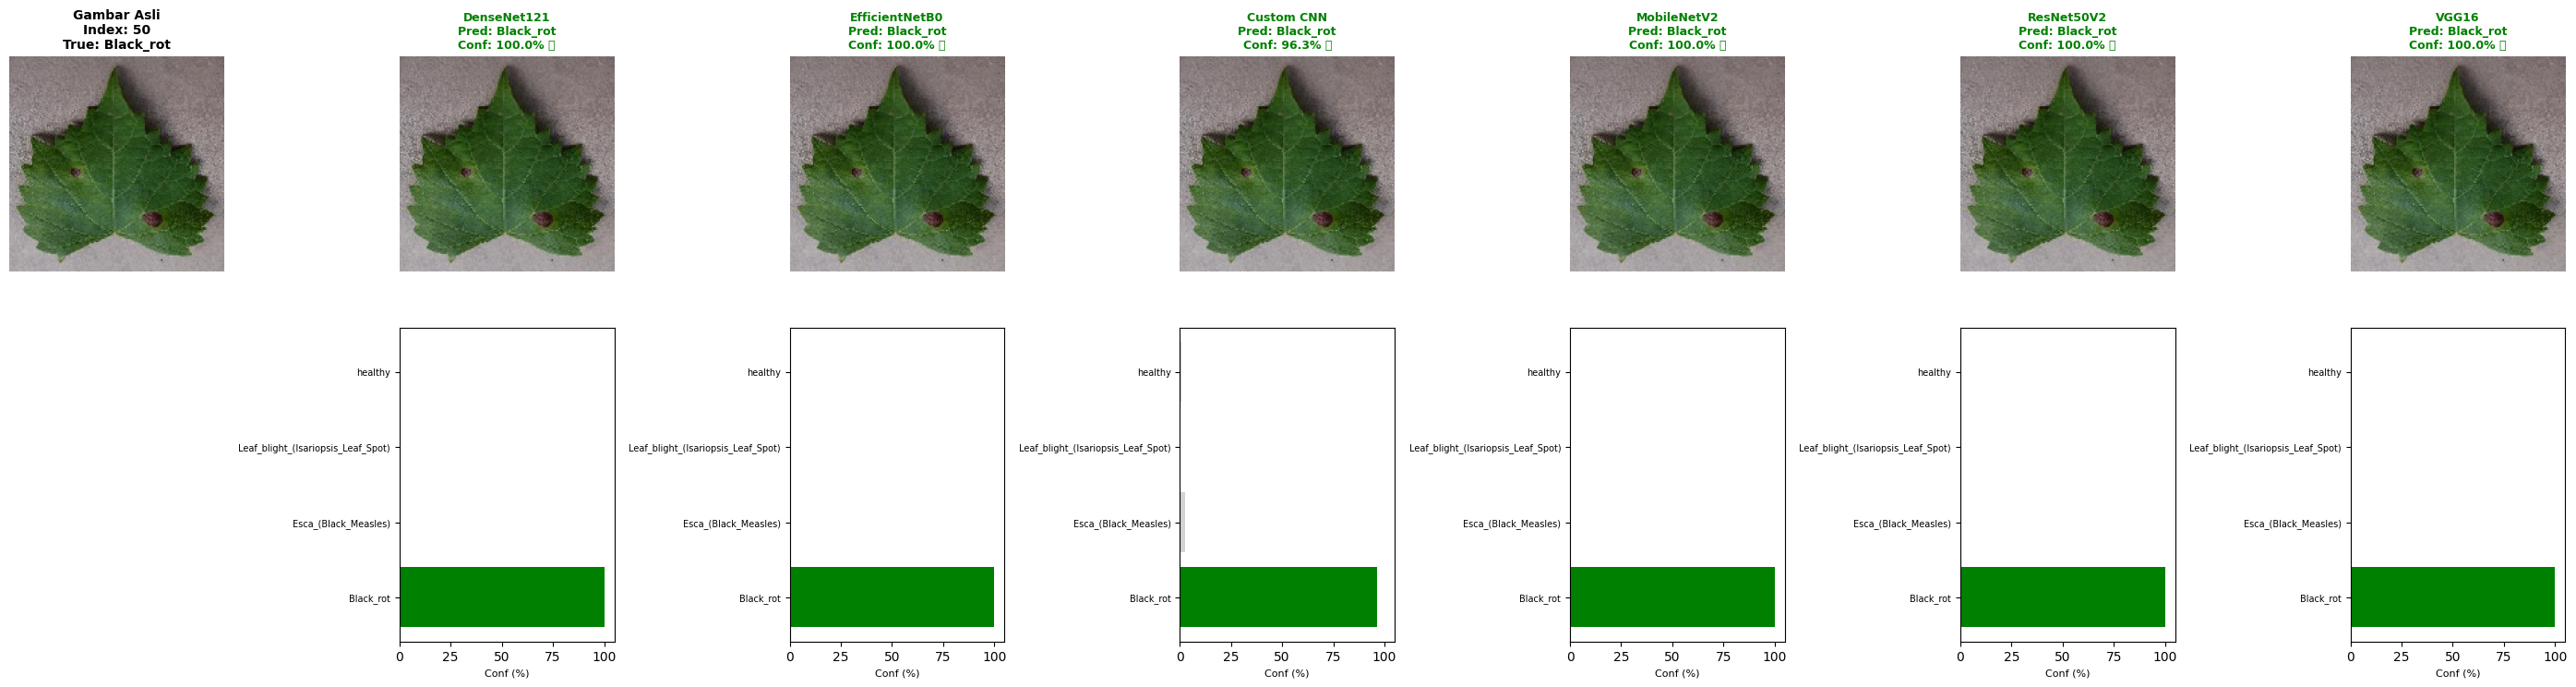


📊 RINGKASAN PREDIKSI:
------------------------------------------------------------
Model yang prediksi BENAR: 6/6
------------------------------------------------------------
   DenseNet121    : Black_rot            (100.0%) ✅
   EfficientNetB0 : Black_rot            (100.0%) ✅
   Custom CNN     : Black_rot            (96.3%) ✅
   MobileNetV2    : Black_rot            (100.0%) ✅
   ResNet50V2     : Black_rot            (100.0%) ✅
   VGG16          : Black_rot            (100.0%) ✅


In [67]:
# --- 6.5 Demo: Bandingkan Semua Model pada Satu Gambar ---

# ============================================
# 🎯 UBAH INDEX DI BAWAH INI UNTUK DEMO
# ============================================
COMPARE_INDEX = 50  # Ganti dengan index gambar yang ingin dibandingkan
# ============================================

results = compare_all_models(image_index=COMPARE_INDEX)

In [68]:
# --- 6.6 Demo: Prediksi Beberapa Gambar Sekaligus ---

def predict_multiple_images(start_index, num_images=8, model_name='DenseNet121'):
    
    # Validasi
    end_index = min(start_index + num_images, len(all_validation_images))
    actual_num = end_index - start_index
    
    if start_index < 0 or start_index >= len(all_validation_images):
        print(f"❌ Error: Index harus antara 0 dan {len(all_validation_images)-1}")
        return
    
    if model_name not in saved_models:
        print(f"❌ Error: Model '{model_name}' tidak ditemukan!")
        return
    
    print("="*60)
    print(f"PREDIKSI {actual_num} GAMBAR (Index {start_index} - {end_index-1})")
    print(f"Model: {model_name}")
    print("="*60)
    
    # --- PERBAIKAN DI SINI ---
    # 1. Ambil builder
    builder = model_predictions[model_name]['builder']
    # 2. Bangun ulang
    model = builder(NUM_CLASSES)
    # 3. Load bobot
    model.load_weights(saved_models[model_name])
    # -------------------------
    
    preproc_func = model_predictions[model_name]['preproc_func']
    
    # Setup plot
    n_cols = 4
    n_rows = (actual_num + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if actual_num > n_cols else [axes] if actual_num == 1 else axes.flatten()
    
    correct_count = 0
    
    for i, idx in enumerate(range(start_index, end_index)):
        img = all_validation_images[idx]
        true_label_idx = all_validation_labels[idx]
        true_label = class_names[true_label_idx].replace('Grape___', '')
        
        # Preprocessing
        if preproc_func is None:
            img_preprocessed = img.copy()
        else:
            img_preprocessed = img * 255
            img_preprocessed = preproc_func(img_preprocessed)
        
        # Prediksi
        img_batch = np.expand_dims(img_preprocessed, axis=0)
        predictions = model.predict(img_batch, verbose=0)
        pred_label_idx = np.argmax(predictions[0])
        pred_label = class_names[pred_label_idx].replace('Grape___', '')
        confidence = predictions[0][pred_label_idx] * 100
        
        is_correct = pred_label_idx == true_label_idx
        if is_correct:
            correct_count += 1
        
        # Plot
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        
        color = 'green' if is_correct else 'red'
        status = '✅' if is_correct else '❌'
        ax.set_title(f'[{idx}] True: {true_label}\nPred: {pred_label} ({confidence:.1f}%) {status}', 
                     fontsize=9, color=color, fontweight='bold')
    
    # Hapus axes kosong
    for i in range(actual_num, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Prediksi {actual_num} Gambar menggunakan {model_name}\nAkurasi: {correct_count}/{actual_num} ({correct_count/actual_num*100:.1f}%)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    # Cleanup
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
    print(f"\n📊 Hasil: {correct_count}/{actual_num} prediksi benar ({correct_count/actual_num*100:.1f}%)")

print("✅ Fungsi predict_multiple_images() siap digunakan!")

✅ Fungsi predict_multiple_images() siap digunakan!


PREDIKSI 8 GAMBAR (Index 0 - 7)
Model: DenseNet121


C:\Users\ROG FLOWX13\AppData\Local\Temp\ipykernel_35976\4012679940.py:78: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


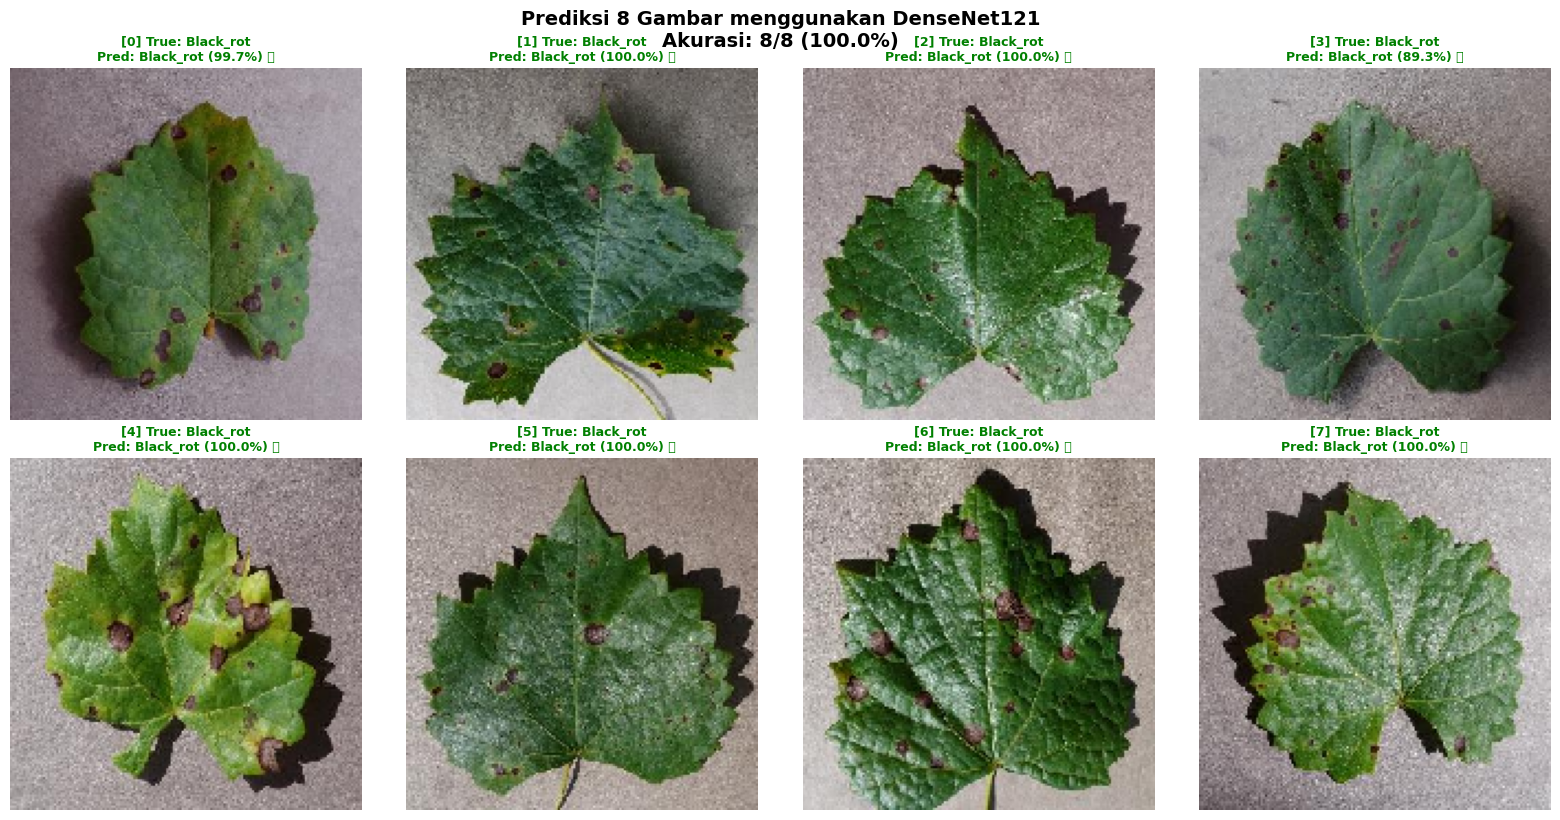


📊 Hasil: 8/8 prediksi benar (100.0%)


In [69]:
# --- 6.7 Demo: Prediksi Beberapa Gambar ---

# ============================================
# 🎯 UBAH NILAI DI BAWAH INI UNTUK DEMO
# ============================================
START_INDEX = 0       # Index awal
NUM_IMAGES = 8        # Jumlah gambar
MODEL = 'DenseNet121' # Model yang digunakan
# ============================================

predict_multiple_images(start_index=START_INDEX, num_images=NUM_IMAGES, model_name=MODEL)

### 📖 Panduan Penggunaan Demo

| Fungsi | Deskripsi | Contoh |
|--------|-----------|--------|
| `predict_by_index(index, model)` | Prediksi 1 gambar dengan 1 model | `predict_by_index(0, 'DenseNet121')` |
| `compare_all_models(index)` | Bandingkan prediksi semua model pada 1 gambar | `compare_all_models(50)` |
| `predict_multiple_images(start, num, model)` | Prediksi beberapa gambar sekaligus | `predict_multiple_images(0, 8, 'DenseNet121')` |

**Model Tersedia:**
- `'DenseNet121'` - Model DenseNet121
- `'EfficientNetB0'` - Model EfficientNet B0
- `'Custom CNN'` - Model CNN Kustom
- `'MobileNetV2'` - Model MobileNet V2
- `'ResNet50V2'` - Model ResNet50 V2
- `'VGG16'` - Model VGG16

**Catatan:**
- Index gambar dimulai dari 0
- Gunakan `len(all_validation_images)` untuk melihat total gambar tersedia